In [77]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from copy import deepcopy
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
train_original = pd.read_csv("dataset/train.csv", parse_dates=["datetime"])
missing_original = pd.read_csv("dataset/test.csv", parse_dates=["datetime"])

## Preprocessing danych

In [3]:
train_processed = deepcopy(train_original)

In [4]:
train_processed["year"] = train_original["datetime"].dt.year.astype(float)
train_processed["month"] = train_original["datetime"].dt.month.astype(float)
train_processed["hour"] = train_original["datetime"].dt.hour.astype(float)

In [5]:
train_processed.drop(columns=["datetime", "holiday", "atemp"], inplace=True)

In [6]:
y_train_casual = train_processed["casual"]
y_train_registered = train_processed["registered"]
x_train_preprocessed = train_processed.drop(columns=["casual", "registered", "count"])

In [7]:
x_train_preprocessed

,season,workingday,weather,temp,humidity,windspeed,year,month,hour
0,1,0,1,9.84,81,0.0000,2011.0,1.0,0.0
1,1,0,1,9.02,80,0.0000,2011.0,1.0,1.0
2,1,0,1,9.02,80,0.0000,2011.0,1.0,2.0
3,1,0,1,9.84,75,0.0000,2011.0,1.0,3.0
4,1,0,1,9.84,75,0.0000,2011.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...
10881,4,1,1,15.58,50,26.0027,2012.0,12.0,19.0
10882,4,1,1,14.76,57,15.0013,2012.0,12.0,20.0
10883,4,1,1,13.94,61,15.0013,2012.0,12.0,21.0
10884,4,1,1,13.94,61,6.0032,2012.0,12.0,22.0


In [8]:
x_train_preprocessed = pd.get_dummies(x_train_preprocessed, columns=["season", "weather"], drop_first=True)

### Właściwa selekcja zmiennych

In [9]:
pd.concat([x_train_preprocessed, y_train_casual], axis=1)

,workingday,temp,humidity,windspeed,year,month,hour,season_2,season_3,season_4,weather_2,weather_3,weather_4,casual
0,0,9.84,81,0.0000,2011.0,1.0,0.0,0,0,0,0,0,0,3
1,0,9.02,80,0.0000,2011.0,1.0,1.0,0,0,0,0,0,0,8
2,0,9.02,80,0.0000,2011.0,1.0,2.0,0,0,0,0,0,0,5
3,0,9.84,75,0.0000,2011.0,1.0,3.0,0,0,0,0,0,0,3
4,0,9.84,75,0.0000,2011.0,1.0,4.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,1,15.58,50,26.0027,2012.0,12.0,19.0,0,0,1,0,0,0,7
10882,1,14.76,57,15.0013,2012.0,12.0,20.0,0,0,1,0,0,0,10
10883,1,13.94,61,15.0013,2012.0,12.0,21.0,0,0,1,0,0,0,4
10884,1,13.94,61,6.0032,2012.0,12.0,22.0,0,0,1,0,0,0,12


In [10]:
features = "+".join(list(x_train_preprocessed.columns))
model = smf.ols("casual~"+features, data = pd.concat([x_train_preprocessed, y_train_casual], axis=1))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 casual   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     763.0
Date:                Mon, 29 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:30:21   Log-Likelihood:                -54495.
No. Observations:               10886   AIC:                         1.090e+05
Df Residuals:                   10872   BIC:                         1.091e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.859e+04   1407.895    -13.204      0.000   -2.13e+04   -1.58e+04
workingday   -36.2138      0.745    -48.599      0.000     -37.674     -34.753
temp           3.1369      0.077     40.897      0.000       2.987       3.287
humidity      -0.7287      0.023    -32.164      0.000      -0.773      -0.684
windspeed     -0.0448      0.046     -0.979      0.328      -0.134       0.045
year           9.2552      0.700     13.224      0.000       7.883      10.627
month          0.6397      0.427      1.497      0.134      -0.198       1.478
hour           1.1304      0.054     21.062      0.000       1.025       1.236
season_2       1.7039      1.764      0.966      0.334      -1.755       5.163
season_3     -12.3928      2.952     -4.198      0.000     -18.179      -6.606
season_4       1.4400      3.949      0.365      0.715      -6.301       9.181
weather_2      2.6962      0.845      3.190      0.001       1.039       4.353
weather_3      0.5007      1.426      0.351      0.726      -2.295       3.296
weather_4     26.5854     36.176      0.735      0.462     -44.326      97.497
==============================================================================
Omnibus:                     4632.751   Durbin-Watson:                   0.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32229.237
Skew:                           1.901   Prob(JB):                         0.00
Kurtosis:                      10.523   Cond. No.                     8.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Można zaobserowować, że zmienne *month, season_2, season_4, weaher_3, weather_4* nie są istotne dla modelu (uwaga, hipoteza w takim brzmi: czy zmienna jest nieistotna przy założeniu, że inne zmienne są istotne) . Możemy je pogrupować w następujący sposób:
- season - w analizie graficznej było widać, że latem i jesienią liczba wypożyczonych rowerów jest prawie taka sama. Scalmy te grupy
- month - na razie zostawmy
- weather - model uznaje zmienne za nieistotne, spróbujmy scalić grupę 2 i 4 (uzasadnienie w analizie danych)
- windspeed - model uznaje zmienną za nieistotną, zostanie ona uzunięta (uzasadnienie w analizie danych)

In [11]:
x_train_new = train_processed.drop(columns=["casual", "registered", "count", "windspeed"])
x_train_new["weather"] = ([2 if x==4 else x for x in x_train_new["weather"]])
x_train_new["season"] = ([1 if x==2 else x for x in x_train_new["season"]])
x_train_new = pd.get_dummies(x_train_new, columns=["season"])

In [12]:
features = "+".join(list(x_train_new.columns))
model = smf.ols("casual~"+features, data = pd.concat([x_train_new, y_train_casual], axis=1))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 casual   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     1101.
Date:                Mon, 29 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:30:21   Log-Likelihood:                -54499.
No. Observations:               10886   AIC:                         1.090e+05
Df Residuals:                   10876   BIC:                         1.091e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.404e+04   1053.708    -13.325      0.000   -1.61e+04    -1.2e+04
workingday   -36.2674      0.745    -48.688      0.000     -37.728     -34.807
weather        1.0799      0.607      1.780      0.075      -0.109       2.269
temp           3.1666      0.070     45.306      0.000       3.030       3.304
humidity      -0.7212      0.022    -33.418      0.000      -0.764      -0.679
year           9.3162      0.698     13.339      0.000       7.947      10.685
month          0.9368      0.309      3.035      0.002       0.332       1.542
hour           1.1176      0.053     20.941      0.000       1.013       1.222
season_1   -4674.5815    351.202    -13.310      0.000   -5363.001   -3986.162
season_3   -4689.4837    351.198    -13.353      0.000   -5377.896   -4001.071
season_4   -4676.1005    351.313    -13.310      0.000   -5364.738   -3987.463
==============================================================================
Omnibus:                     4620.410   Durbin-Watson:                   0.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32004.606
Skew:                           1.897   Prob(JB):                         0.00
Kurtosis:                      10.495   Cond. No.                     6.05e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.2e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Na poziomie istotności 5% model uznaje prawie wszystkie zmienne za istotne. Na granicyjest cecha *weather*, jednakże pozostanie ona w modelu. $R^2$ uzyskało taką samą wartość dla modelu z mniejszą jak i więkoszą ilością zmiennnych. Sprawdzono to również dla zmienniej objaśnianej *registered*. Wyniki są analogiczne. Te 2 warianty danych wejściowych będą użyte do predykcji.

Założenie o rozkładnie normalnym reszt jest spełnione dla testu JB oraz Omnibus.
Statystyka Durbina-Watsona wskazuje na to, że reszty są skorelowane, co jest typowe dla szeregów czasowych.


## Predykcje dla brakujących danych
Z powodu skorelowanych reszt, budowanie modelu regresji liniowej nie będzie prawidłowym podejściem. Dla potwierdzenia sprawdzę jeszcze stacjonarność szeregu.

In [45]:
print(adfuller(y_train_casual)[1], adfuller(y_train_registered)[1])

2.1061561974387805e-18 4.9213427695846915e-11


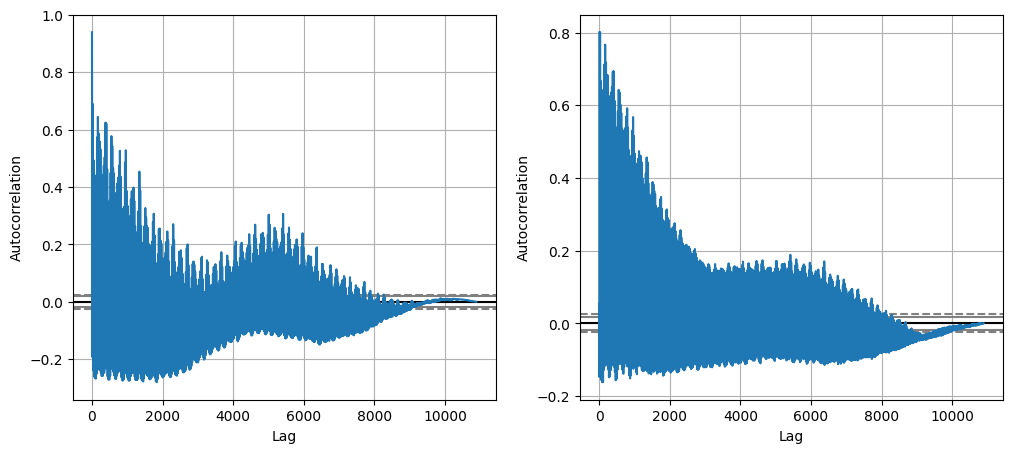

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
pd.plotting.autocorrelation_plot(y_train_casual, ax=axes[0])
pd.plotting.autocorrelation_plot(y_train_registered, ax=axes[1])
plt.show()

Test Dickey-Fullera wskazuje nam, że szereg jest stacjonarny, jednakże graficzna ewaluacja autokorelacji kolejnych wyrazów szeregu odrzuca hipotezę, że szereg jest stacjonarny. W związku z tym użyję lasów losowych

In [99]:
params = {'n_estimators': np.arange(25, 150, 25),'max_depth':np.arange(1, 11, 1),'min_samples_leaf':np.arange(1, 11, 2)}

grid = GridSearchCV(RandomForestRegressor(), params, cv=4, verbose=2, scoring='r2')
grid.fit(x_train_preprocessed, y_train_casual)
grid_2 = GridSearchCV(RandomForestRegressor(), params, cv=4, verbose=2, scoring='r2')
grid_2.fit(x_train_preprocessed, y_train_registered)

grid_new = GridSearchCV(RandomForestRegressor(), params, cv=4, verbose=2, scoring='r2')
grid_new.fit(x_train_new, y_train_casual)
grid_new_2 = GridSearchCV(RandomForestRegressor(), params, cv=4, verbose=2, scoring='r2')
grid_new_2.fit(x_train_new, y_train_registered)

Fitting 4 folds for each of 250 candidates, totalling 1000 fits
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=1, min_samples_leaf=1, 

[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=75; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_

[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=75; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=1, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=1, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=1, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=1, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_

[CV] END ...max_depth=4, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=1, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=4, min_samples_leaf=1, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=4, min_samples_leaf=1, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=4, min_samples_leaf=1, n_estimators=75; total time=   0.3s
[CV] END ..max_depth=4, min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ..max_depth=4, min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ..max_depth=4, min_

[CV] END ...max_depth=5, min_samples_leaf=1, n_estimators=75; total time=   0.4s
[CV] END ...max_depth=5, min_samples_leaf=1, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=1, n_estimators=75; total time=   0.4s
[CV] END ...max_depth=5, min_samples_leaf=1, n_estimators=75; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=125; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=125; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=125; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=125; total time=   0.7s
[CV] END ...max_depth=5, min

[CV] END ...max_depth=6, min_samples_leaf=1, n_estimators=75; total time=   0.4s
[CV] END ...max_depth=6, min_samples_leaf=1, n_estimators=75; total time=   0.4s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=125; total time=   0.8s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=125; total time=   0.8s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=125; total time=   0.8s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=125; total time=   0.9s
[CV] END ...max_depth=6, min_samples_leaf=3, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=3, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=6, min

[CV] END ..max_depth=7, min_samples_leaf=1, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=1, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=1, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=1, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=1, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=7, min_samples_leaf=1, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=7, min_samples_leaf=1, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=7, min_samples_leaf=1, n_estimators=125; total time=   0.9s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min

[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=100; total time=   0.9s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=125; total time=   1.2s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=125; total time=   1.1s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=125; total time=   1.1s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=125; total time=   1.1s
[CV] END ...max_depth=8, min_samples_leaf=3, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=3, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=3, n_estimators=25; total time=   0.2s
[CV] END ...max_depth=8, min_samples_leaf=3, n_estimators=25; total time=   0.2s
[CV] END ...max_depth=8, min_samples_leaf=3, n_estimators=50; total time=   0.5s
[CV] END ...max_depth=8, min_samples_leaf=3, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=8, min

[CV] END ..max_depth=9, min_samples_leaf=1, n_estimators=125; total time=   1.2s
[CV] END ..max_depth=9, min_samples_leaf=1, n_estimators=125; total time=   1.2s
[CV] END ..max_depth=9, min_samples_leaf=1, n_estimators=125; total time=   1.2s
[CV] END ..max_depth=9, min_samples_leaf=1, n_estimators=125; total time=   1.2s
[CV] END ...max_depth=9, min_samples_leaf=3, n_estimators=25; total time=   0.2s
[CV] END ...max_depth=9, min_samples_leaf=3, n_estimators=25; total time=   0.2s
[CV] END ...max_depth=9, min_samples_leaf=3, n_estimators=25; total time=   0.2s
[CV] END ...max_depth=9, min_samples_leaf=3, n_estimators=25; total time=   0.2s
[CV] END ...max_depth=9, min_samples_leaf=3, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=9, min_samples_leaf=3, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=9, min_samples_leaf=3, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=9, min_samples_leaf=3, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=9, min

[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=125; total time=   1.3s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=125; total time=   1.3s
[CV] END ..max_depth=10, min_samples_leaf=3, n_estimators=25; total time=   0.2s
[CV] END ..max_depth=10, min_samples_leaf=3, n_estimators=25; total time=   0.2s
[CV] END ..max_depth=10, min_samples_leaf=3, n_estimators=25; total time=   0.2s
[CV] END ..max_depth=10, min_samples_leaf=3, n_estimators=25; total time=   0.2s
[CV] END ..max_depth=10, min_samples_leaf=3, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=10, min_samples_leaf=3, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=10, min_samples_leaf=3, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=10, min_samples_leaf=3, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=10, min_samples_leaf=3, n_estimators=75; total time=   0.7s
[CV] END ..max_depth=10, min_samples_leaf=3, n_estimators=75; total time=   0.7s
[CV] END ..max_depth=10, min

[CV] END ..max_depth=1, min_samples_leaf=1, n_estimators=125; total time=   0.2s
[CV] END ...max_depth=1, min_samples_leaf=3, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=3, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=3, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=3, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=3, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=3, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=3, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=3, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=3, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=1, min_samples_leaf=3, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=1, min_samples_leaf=3, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=1, min

[CV] END ...max_depth=2, min_samples_leaf=3, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=3, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=3, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=3, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=3, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=3, n_estimators=75; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_

[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=75; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_

[CV] END ...max_depth=4, min_samples_leaf=3, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=3, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=3, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=4, min_samples_leaf=3, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=4, min_samples_leaf=3, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=4, min_samples_leaf=3, n_estimators=75; total time=   0.3s
[CV] END ..max_depth=4, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=3, n_estimators=125; total time=   0.5s
[CV] END ..max_depth=4, min_samples_leaf=3, n_estimators=125; total time=   0.5s
[CV] END ..max_depth=4, min_

[CV] END ...max_depth=5, min_samples_leaf=3, n_estimators=75; total time=   0.4s
[CV] END ...max_depth=5, min_samples_leaf=3, n_estimators=75; total time=   0.4s
[CV] END ...max_depth=5, min_samples_leaf=3, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=3, n_estimators=75; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=3, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=3, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=3, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=3, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=3, n_estimators=125; total time=   0.7s
[CV] END ..max_depth=5, min_samples_leaf=3, n_estimators=125; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=3, n_estimators=125; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=3, n_estimators=125; total time=   0.6s
[CV] END ...max_depth=5, min

[CV] END ...max_depth=6, min_samples_leaf=3, n_estimators=75; total time=   0.4s
[CV] END ...max_depth=6, min_samples_leaf=3, n_estimators=75; total time=   0.4s
[CV] END ..max_depth=6, min_samples_leaf=3, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=6, min_samples_leaf=3, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=6, min_samples_leaf=3, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=6, min_samples_leaf=3, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=6, min_samples_leaf=3, n_estimators=125; total time=   0.8s
[CV] END ..max_depth=6, min_samples_leaf=3, n_estimators=125; total time=   0.8s
[CV] END ..max_depth=6, min_samples_leaf=3, n_estimators=125; total time=   0.8s
[CV] END ..max_depth=6, min_samples_leaf=3, n_estimators=125; total time=   0.8s
[CV] END ...max_depth=6, min_samples_leaf=5, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=5, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=6, min

[CV] END ..max_depth=7, min_samples_leaf=3, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=3, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=3, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=3, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=3, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=7, min_samples_leaf=3, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=7, min_samples_leaf=3, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=7, min_samples_leaf=3, n_estimators=125; total time=   0.9s
[CV] END ...max_depth=7, min_samples_leaf=5, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=5, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=5, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=5, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min

[CV] END ..max_depth=8, min_samples_leaf=3, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=8, min_samples_leaf=3, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=8, min_samples_leaf=3, n_estimators=125; total time=   1.0s
[CV] END ..max_depth=8, min_samples_leaf=3, n_estimators=125; total time=   1.0s
[CV] END ..max_depth=8, min_samples_leaf=3, n_estimators=125; total time=   1.0s
[CV] END ..max_depth=8, min_samples_leaf=3, n_estimators=125; total time=   1.0s
[CV] END ...max_depth=8, min_samples_leaf=5, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=5, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=5, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=5, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=8, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=8, min

[CV] END ..max_depth=9, min_samples_leaf=3, n_estimators=125; total time=   1.2s
[CV] END ..max_depth=9, min_samples_leaf=3, n_estimators=125; total time=   1.2s
[CV] END ..max_depth=9, min_samples_leaf=3, n_estimators=125; total time=   1.2s
[CV] END ..max_depth=9, min_samples_leaf=3, n_estimators=125; total time=   1.1s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=25; total time=   0.2s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=25; total time=   0.2s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=25; total time=   0.2s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=25; total time=   0.2s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=9, min

[CV] END .max_depth=10, min_samples_leaf=3, n_estimators=125; total time=   1.3s
[CV] END .max_depth=10, min_samples_leaf=3, n_estimators=125; total time=   1.3s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=25; total time=   0.2s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=25; total time=   0.2s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=25; total time=   0.2s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=25; total time=   0.2s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=75; total time=   0.7s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=75; total time=   0.7s
[CV] END ..max_depth=10, min

[CV] END ..max_depth=1, min_samples_leaf=3, n_estimators=125; total time=   0.1s
[CV] END ...max_depth=1, min_samples_leaf=5, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=5, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=5, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=5, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=5, n_estimators=75; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=5, n_estimators=75; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=5, n_estimators=75; total time=   0.0s
[CV] END ...max_depth=1, min

[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=75; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=5, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_samples_leaf=5, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_

[CV] END ...max_depth=3, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=5, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=5, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=5, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=5, n_estimators=75; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_

[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=75; total time=   0.2s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=125; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=125; total time=   0.5s
[CV] END ..max_depth=4, min_

[CV] END ...max_depth=5, min_samples_leaf=5, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=5, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=5, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=5, n_estimators=75; total time=   0.3s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=125; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=125; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=125; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=125; total time=   0.5s
[CV] END ...max_depth=5, min

[CV] END ...max_depth=6, min_samples_leaf=5, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=6, min_samples_leaf=5, n_estimators=75; total time=   0.4s
[CV] END ..max_depth=6, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=6, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=6, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=6, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=6, min_samples_leaf=5, n_estimators=125; total time=   0.7s
[CV] END ..max_depth=6, min_samples_leaf=5, n_estimators=125; total time=   0.6s
[CV] END ..max_depth=6, min_samples_leaf=5, n_estimators=125; total time=   0.6s
[CV] END ..max_depth=6, min_samples_leaf=5, n_estimators=125; total time=   0.6s
[CV] END ...max_depth=6, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=6, min

[CV] END ..max_depth=7, min_samples_leaf=5, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=7, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=5, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=7, min_samples_leaf=5, n_estimators=125; total time=   0.8s
[CV] END ..max_depth=7, min_samples_leaf=5, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=7, min_samples_leaf=5, n_estimators=125; total time=   0.9s
[CV] END ...max_depth=7, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min

[CV] END ..max_depth=8, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=8, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=8, min_samples_leaf=5, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=8, min_samples_leaf=5, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=8, min_samples_leaf=5, n_estimators=125; total time=   0.8s
[CV] END ..max_depth=8, min_samples_leaf=5, n_estimators=125; total time=   0.8s
[CV] END ...max_depth=8, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=8, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=8, min

[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=125; total time=   1.0s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=125; total time=   1.0s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=125; total time=   1.0s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=125; total time=   1.0s
[CV] END ...max_depth=9, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min

[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=125; total time=   1.0s
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=125; total time=   1.0s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=75; total time=   0.6s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=75; total time=   0.6s
[CV] END ..max_depth=10, min

[CV] END ..max_depth=1, min_samples_leaf=5, n_estimators=125; total time=   0.1s
[CV] END ...max_depth=1, min_samples_leaf=7, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=7, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=7, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=7, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=7, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=7, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=7, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=7, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=7, n_estimators=75; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=7, n_estimators=75; total time=   0.0s
[CV] END ...max_depth=1, min_samples_leaf=7, n_estimators=75; total time=   0.0s
[CV] END ...max_depth=1, min

[CV] END ...max_depth=2, min_samples_leaf=7, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=7, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=7, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=7, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=7, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=7, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=7, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=7, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=7, n_estimators=75; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=7, n_estimators=75; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=7, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_samples_leaf=7, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_

[CV] END ...max_depth=3, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=7, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=7, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=7, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=7, n_estimators=75; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_

[CV] END ...max_depth=4, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=4, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=4, min_samples_leaf=7, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=7, n_estimators=75; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=7, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=4, min_samples_leaf=7, n_estimators=75; total time=   0.2s
[CV] END ..max_depth=4, min_samples_leaf=7, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=4, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=4, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=4, min_samples_leaf=7, n_estimators=125; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=7, n_estimators=125; total time=   0.4s
[CV] END ..max_depth=4, min_

[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=75; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=75; total time=   0.3s
[CV] END ..max_depth=5, min_samples_leaf=7, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=7, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=7, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=7, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=7, n_estimators=125; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=7, n_estimators=125; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=7, n_estimators=125; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=7, n_estimators=125; total time=   0.5s
[CV] END ...max_depth=5, min

[CV] END ...max_depth=6, min_samples_leaf=7, n_estimators=75; total time=   0.4s
[CV] END ...max_depth=6, min_samples_leaf=7, n_estimators=75; total time=   0.3s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=125; total time=   0.7s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=125; total time=   0.6s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=125; total time=   0.7s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=125; total time=   0.6s
[CV] END ...max_depth=6, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=6, min

[CV] END ..max_depth=7, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=7, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=7, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=7, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=7, min_samples_leaf=7, n_estimators=125; total time=   0.8s
[CV] END ..max_depth=7, min_samples_leaf=7, n_estimators=125; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=7, n_estimators=125; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=7, n_estimators=125; total time=   0.7s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=7, min

[CV] END ..max_depth=8, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=8, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=8, min_samples_leaf=7, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=8, min_samples_leaf=7, n_estimators=125; total time=   0.8s
[CV] END ..max_depth=8, min_samples_leaf=7, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=8, min_samples_leaf=7, n_estimators=125; total time=   0.8s
[CV] END ...max_depth=8, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=8, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=8, min

[CV] END ..max_depth=9, min_samples_leaf=7, n_estimators=125; total time=   1.0s
[CV] END ..max_depth=9, min_samples_leaf=7, n_estimators=125; total time=   0.9s
[CV] END ..max_depth=9, min_samples_leaf=7, n_estimators=125; total time=   1.0s
[CV] END ..max_depth=9, min_samples_leaf=7, n_estimators=125; total time=   0.9s
[CV] END ...max_depth=9, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min

[CV] END .max_depth=10, min_samples_leaf=7, n_estimators=125; total time=   1.0s
[CV] END .max_depth=10, min_samples_leaf=7, n_estimators=125; total time=   1.0s
[CV] END ..max_depth=10, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=9, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=9, n_estimators=75; total time=   0.6s
[CV] END ..max_depth=10, min_samples_leaf=9, n_estimators=75; total time=   0.6s
[CV] END ..max_depth=10, min

GridSearchCV(cv=4, estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_leaf': array([1, 3, 5, 7, 9]),
                         'n_estimators': array([ 25,  50,  75, 100, 125])},
             scoring='r2', verbose=2)

In [100]:
grid.best_score_, grid_2.best_score_, grid_new.best_score_, grid_new_2.best_score_

(0.7293940693910429,
 0.7456327351102775,
 0.7379724483819476,
 0.7464407033535438)

Najlepszy $R^2$ score został uzyskany dla mniejszej liczby cech w modelu. Dopasowanie datasetu:

In [122]:
missing_to_predict = deepcopy(missing_original)
missing_to_predict["year"] = missing_to_predict["datetime"].dt.year.astype(float)
missing_to_predict["month"] = missing_to_predict["datetime"].dt.month.astype(float)
missing_to_predict["hour"] = missing_to_predict["datetime"].dt.hour.astype(float)
missing_to_predict = missing_to_predict.drop(columns=["windspeed", "holiday", "datetime", "atemp"])
missing_to_predict["weather"] = ([2 if x==4 else x for x in missing_to_predict["weather"]])
missing_to_predict["season"] = ([1 if x==2 else x for x in missing_to_predict["season"]])
missing_to_predict = pd.get_dummies(missing_to_predict, columns=["season"])

In [159]:
rf_casual_best = RandomForestRegressor(**grid_new.best_params_)
rf_casual_best.fit(x_train_new, y_train_casual)
preds_casual = rf_casual_best.predict(missing_to_predict)

rf_registered_best = RandomForestRegressor(**grid_new_2.best_params_)
rf_registered_best.fit(x_train_new, y_train_registered)
preds_registered = rf_registered_best.predict(missing_to_predict)

In [160]:
preds_count = preds_casual + preds_registered

In [161]:
predicted_data = deepcopy(missing_original)
predicted_data["casual"] = preds_casual
predicted_data["registered"] = preds_registered
predicted_data["count"] = preds_count

In [164]:
predicted_data.to_csv("dataset/test_predicted.csv", index=False)